In [ ]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [2]:
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

In [3]:
np.random.seed(1234)

In [8]:
# load raw data
df_raw = pd.read_csv("hourly_load_2016.csv", header=None)

In [11]:
df_raw.head()
# numpy array
df_raw_array = df_raw.values

In [12]:
# daily load
list_daily_load = [df_raw_array[i,:] for i in range(0, len(df_raw)) if i % 24 == 0]

In [13]:
list_daily_load

[array(['1/1/2016', 1311693.43], dtype=object),
 array(['1/2/2016', 1296008.18], dtype=object),
 array(['1/3/2016', 1346408.94], dtype=object),
 array(['1/4/2016', 1531778.93], dtype=object),
 array(['1/5/2016', 1657504.05], dtype=object),
 array(['1/6/2016', 1580280.3], dtype=object),
 array(['1/7/2016', 1511573.18], dtype=object),
 array(['1/8/2016', 1487156.94], dtype=object),
 array(['1/9/2016', 1473401.73], dtype=object),
 array(['1/10/2016', 1378044.04], dtype=object),
 array(['1/11/2016', 1460451.24], dtype=object),
 array(['1/12/2016', 1546342.39], dtype=object),
 array(['1/13/2016', 1611857.17], dtype=object),
 array(['1/14/2016', 1650448.07], dtype=object),
 array(['1/15/2016', 1559197.35], dtype=object),
 array(['1/16/2016', 1489451.07], dtype=object),
 array(['1/17/2016', 1518757.52], dtype=object),
 array(['1/18/2016', 1551637.97], dtype=object),
 array(['1/19/2016', 1635562.26], dtype=object),
 array(['1/20/2016', 1442777.86], dtype=object),
 array(['1/21/2016', 1421876.3

In [14]:
# hourly load (23 loads for each day)
list_hourly_load = [df_raw_array[i,1]/100000 for i in range(0, len(df_raw)) if i % 24 != 0]

In [15]:
# the length of the sequnce for predicting the future value
sequence_length = 23

In [16]:
# convert the vector to a 2D matrix
matrix_load = convertSeriesToMatrix(list_hourly_load, sequence_length)

In [17]:
# shift all data by mean
matrix_load = np.array(matrix_load)
shifted_value = matrix_load.mean()
matrix_load -= shifted_value
print ("Data  shape: ", matrix_load.shape)

Data  shape:  (4877, 23)


In [19]:
# split dataset: 90% for training and 10% for testing
train_row = int(round(0.9 * matrix_load.shape[0]))
train_set = matrix_load[:train_row, :]

In [20]:
# shuffle the training set (but do not shuffle the test set)
np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]

In [21]:
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1] 
# the test set
X_test = matrix_load[train_row:, :-1]
y_test = matrix_load[train_row:, -1]

In [22]:
# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [23]:
# build the model
model = Sequential()

W0711 10:09:37.580893 22232 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [24]:
# layer 1: LSTM
model.add(LSTM( input_dim=1, output_dim=50, return_sequences=True))
model.add(Dropout(0.2))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  
W0711 10:10:01.754793 22232 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 10:10:01.809003 22232 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 10:10:02.426970 22232 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1

In [25]:
# layer 2: LSTM
model.add(LSTM(output_dim=100, return_sequences=False))
model.add(Dropout(0.2))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, units=100)`
  


In [26]:
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(output_dim=1, activation='linear'))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
# compile the model
model.compile(loss="mse", optimizer="rmsprop")

W0711 10:10:44.702708 22232 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [28]:
# train the model
model.fit(X_train, y_train, batch_size=512, nb_epoch=50, validation_split=0.05, verbose=1)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W0711 10:10:57.333439 22232 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0711 10:11:00.498675 22232 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 4169 samples, validate on 220 samples
Epoch 1/50
4169/4169 [==============================] - 8s 2ms/step - loss: 7.4487 - val_loss: 5.5209
Epoch 2/50
4169/4169 [==============================] - 3s 711us/step - loss: 5.0435 - val_loss: 3.7022
Epoch 3/50
4169/4169 [==============================] - 3s 614us/step - loss: 3.8023 - val_loss: 3.1621
Epoch 4/50
4169/4169 [==============================] - 3s 667us/step - loss: 2.9441 - val_loss: 2.0857
Epoch 5/50
4169/4169 [==============================] - 3s 816us/step - loss: 2.4368 - val_loss: 1.7791
Epoch 6/50
4169/4169 [==============================] - 3s 811us/step - loss: 1.9393 - val_loss: 1.3472
Epoch 7/50
4169/4169 [==============================] - 3s 729us/step - loss: 1.5062 - val_loss: 1.6458
Epoch 8/50
4169/4169 [==============================] - 3s 816us/step - loss: 1.3239 - val_loss: 1.0113
Epoch 9/50
4169/4169 [==============================] - 3s 780us/step - loss: 1.1703 - val_loss: 0.8360
Epoch 10/50
4169/41

In [29]:
# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

488/488 [==============================] - 0s 251us/step

The mean squared error (MSE) on the test data set is 0.313 over 488 test samples.


In [30]:
# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

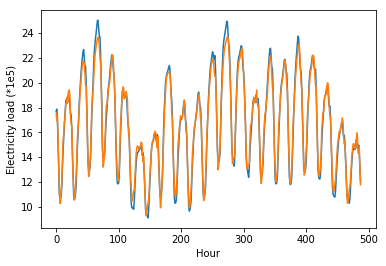

In [31]:
# plot the results
fig = plt.figure()
plt.plot(y_test + shifted_value)
plt.plot(predicted_values + shifted_value)
plt.xlabel('Hour')
plt.ylabel('Electricity load (*1e5)')
plt.show()
fig.savefig('output_load_forecasting.jpg', bbox_inches='tight')

In [33]:

# save the result into txt file
test_result = np.vstack((predicted_values, y_test)) + shifted_value
np.savetxt('output_load_forecasting_result.txt', test_result)

ValueError: all the input array dimensions except for the concatenation axis must match exactly